In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import preprocess_input
import warnings
from keras.applications.vgg19 import VGG19
import tensorflow as tf
from PIL import Image, ImageFile
import PIL.Image
import numpy as np
import matplotlib.pyplot as plt

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [57]:
print("GPU name: ", tf.config.experimental.list_physical_devices("GPU"))

GPU name:  []


In [2]:
NUM_THREADS = 4
tf.config.threading.set_inter_op_parallelism_threads(NUM_THREADS)
tf.config.threading.set_intra_op_parallelism_threads(NUM_THREADS)

# Data

Our data will is in the DATASET folder split into our TRAIN and TEST datasets. Each folder contains one folder for each of our labels. Our next step will be to preprocess our data.

- We use ImageDataGenerator to do some transformations of the images
- Then we can apply the transformations to the directories for our train and test folder


In [14]:
train_dir = "DATASET/CK+48"
test_dir = "DATASET/TEST"


In [ ]:
# test gray scale image to rgb function

img = tf.keras.utils.load_img("DATASET/TEST/happy/PrivateTest_10470092.jpg")
# summarize some details about the image
print(img.format)
print(img.mode)
# summarize shape
# print(tf_img.shape)
# print(img)
# tf.shape(image)
image = tf.image.grayscale_to_rgb(img)
image = tf.convert_to_tensor(image)

print(image.shape)


In [3]:
# transform train gray images to rgb
def from_grayscale_to_rgb(image):
    image = tf.convert_to_tensor(image)
    # tf.expand_dims(image, -1).shape.as_list()
    print(f"convert to tensor {image.shape}")
    image = tf.image.grayscale_to_rgb(image)
    print(f"convert gray to rgb {image.shape}")
    # image_np = image.numpy()
    # print(f"convert gray to numpy {image.shape}")
    return image

In [15]:
# Extending preprocessing from VGG19
def our_preprocessing_function(image):
    # Combines all the transformations
    # img = from_grayscale_to_rgb(image)
    final_img = preprocess_input(image)
    return final_img


In [16]:
train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    horizontal_flip=True,
    rescale=1.0 / 255,
    validation_split=0.2,
    preprocessing_function=our_preprocessing_function,
)
test_datagen = ImageDataGenerator(
    rescale=1.0 / 255, preprocessing_function=preprocess_input
)

In [18]:
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(48, 48),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=16,
    subset="training",
)
validation_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(48, 48),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=16,
    subset="validation",
)

Found 788 images belonging to 7 classes.
Found 193 images belonging to 7 classes.


In [19]:
print(validation_generator.class_indices)
print(train_generator.class_indices)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [20]:
def compute_weights(train_generator):
    unique, counts = np.unique(train_generator.classes, return_counts=True)
    classes_count = dict(zip(unique, counts))
    print(classes_count)
    # Determine the number of samples in the smallest class
    num_samples_per_class = min(classes_count.values())
    # Use class weights to balance the dataset during training
    class_weights = {
        c: num_samples_per_class / classes_count[c]
        for c in range(train_generator.num_classes)
    }
    return class_weights


class_weights = compute_weights(train_generator)
print(class_weights)

{0: 108, 1: 142, 2: 60, 3: 166, 4: 44, 5: 68, 6: 200}
{0: 0.4074074074074074, 1: 0.30985915492957744, 2: 0.7333333333333333, 3: 0.26506024096385544, 4: 1.0, 5: 0.6470588235294118, 6: 0.22}


We will use the VGG19 model you can read more about the requirements and considerations for this model in the documentation (https://keras.io/api/applications/vgg/).


In [21]:
model = VGG19(include_top=False, weights="imagenet", input_shape=(48, 48, 3))

# Freeze the imported layers so they cannot be retrained.
for layer in model.layers:
    layer.trainable = False


model.summary()


Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

### Adding flattening and dense layers

Right now, our model is missing a top to actually classify our features. Let's add them:


In [22]:
from keras import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout

new_model = Sequential()
new_model.add(model)
new_model.add(Flatten())
new_model.add(Dense(49, activation="relu"))

new_model.add(Dropout(0.3))
new_model.add(Dense(7, activation="softmax"))

# Summarize.
new_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 49)                25137     
                                                                 
 dropout_1 (Dropout)         (None, 49)                0         
                                                                 
 dense_3 (Dense)             (None, 7)                 350       
                                                                 
Total params: 20,049,871
Trainable params: 25,487
Non-trainable params: 20,024,384
_________________________________________________________________


In [23]:
# This callback will stop the training when there is no improvement in
# the loss for three consecutive epochs.
callback = tf.keras.callbacks.EarlyStopping(monitor="accuracy", patience=3)

In [24]:
from tensorflow.keras.optimizers import Adam

# Compile and fit the model. Use the Adam optimizer and crossentropical loss.
# Use the validation data argument during fitting to include your validation data.
optimizer = Adam(learning_rate=0.0001)
new_model.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)
history = new_model.fit(
    train_generator,
    epochs=20,
    batch_size=16,
    validation_data=validation_generator,
    callbacks=[callback],
    class_weight=class_weights,
)

len(history.history["accuracy"])

Epoch 1/20
50/50 [==============================] - 7s 135ms/step - loss: 0.9078 - accuracy: 0.2272 - val_loss: 1.9317 - val_accuracy: 0.2591
Epoch 2/20
50/50 [==============================] - 6s 110ms/step - loss: 0.8209 - accuracy: 0.2132 - val_loss: 1.8620 - val_accuracy: 0.2487
Epoch 3/20
50/50 [==============================] - 5s 109ms/step - loss: 0.7837 - accuracy: 0.2360 - val_loss: 1.8263 - val_accuracy: 0.2591
Epoch 4/20
50/50 [==============================] - 6s 110ms/step - loss: 0.7530 - accuracy: 0.2602 - val_loss: 1.7973 - val_accuracy: 0.3057
Epoch 5/20
50/50 [==============================] - 5s 107ms/step - loss: 0.7370 - accuracy: 0.3008 - val_loss: 1.7818 - val_accuracy: 0.3575
Epoch 6/20
50/50 [==============================] - 5s 107ms/step - loss: 0.7233 - accuracy: 0.3211 - val_loss: 1.7495 - val_accuracy: 0.3731
Epoch 7/20
50/50 [==============================] - 5s 107ms/step - loss: 0.7035 - accuracy: 0.3350 - val_loss: 1.7296 - val_accuracy: 0.3886
Epoch 

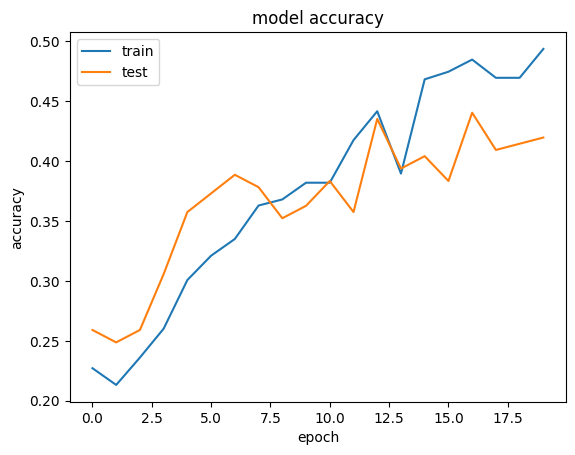

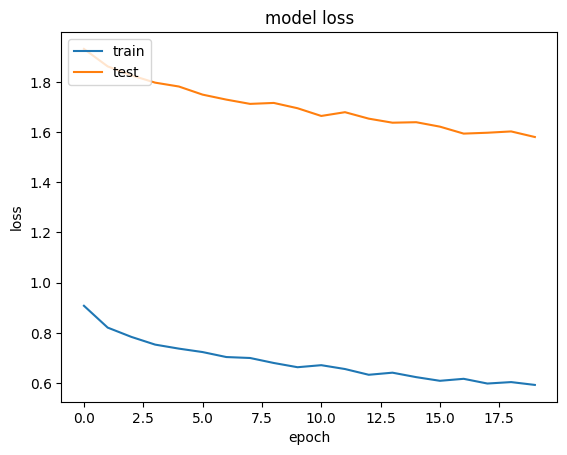

In [25]:
print(history)
# summarize history for accuracy
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()
# summarize history for loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()


# Predicting the class of your image

Let's take this bad boy for a spin! Can your image get properly identified?


In [26]:
import numpy as np
from tensorflow.keras.applications.vgg19 import preprocess_input

# Predict the class of your picture.

img = tf.keras.preprocessing.image.load_img(
    "./test_folder/maité.png", target_size=(48, 48)
)


img_nparray = tf.keras.preprocessing.image.img_to_array(img)

print(img_nparray.shape)
# convert image to array

x = preprocess_input(img_nparray).reshape((1, 48, 48, 3))

print(x.shape)

prediction = new_model.predict(x)

print(prediction.shape)

# create a list containing the class labels
# class_labels = ["downdog", "goddess", "plank", "tree", "warrior2"]
class_labels = list(validation_generator.class_indices.keys())
print(class_labels)

# find the index of the class with maximum score
pred = np.argmax(prediction, axis=-1)
class_labels[pred[0]]

(48, 48, 3)
(1, 48, 48, 3)
1/1 [==============================] - 0s 150ms/step
(1, 7)
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


'happy'